In [1]:
%cd /home/jeroen/repos/traffic-scheduling/single

/home/jeroen/repos/traffic-scheduling/single


In [2]:
import numpy as np
rng = np.random.default_rng()
from automaton import Automaton
from util import plot_schedule

### Instance generation

In [3]:
vehicle_l, vehicle_w = 4, 1

In [4]:
def cumulate(lane):
    def inner(n):
        lengths, gaps = lane(n)
        shifted = np.roll(lengths, 1); shifted[0] = 0
        releases = np.cumsum(gaps + shifted)
        return {'length': [lengths], 'release': [releases]}
    return inner

In [351]:
lane_gen = {}
lane_gen[0] = lambda n: (np.repeat(vehicle_l, n), rng.uniform(1, 4, size=(n)))
lane_gen[1] = lambda n: (np.repeat(vehicle_l, n), rng.uniform(1, 8, size=(n)))
lane_gen[2] = lambda n: (np.repeat(vehicle_l, n), rng.exponential(scale=4, size=(n)))
lane_gen[3] = lambda n: (np.repeat(vehicle_l, n), rng.exponential(scale=6, size=(n)))

def multimodal(n):
    p = rng.binomial(1, 0.3, size=(n))
    return (1-p) * rng.exponential(scale=1, size=(n)) + p * rng.exponential(scale=15, size=(n))

lane_gen[4] = lambda n: (np.repeat(vehicle_l, n), multimodal(n))

Show some examples of lane distributions.

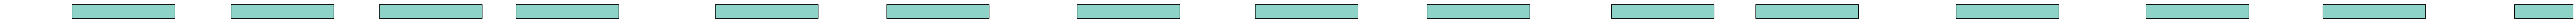

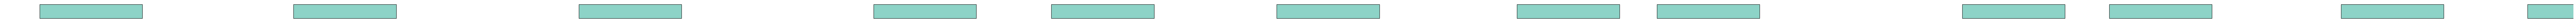

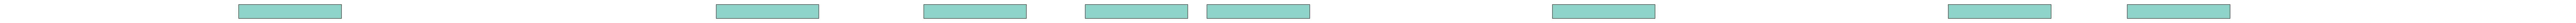

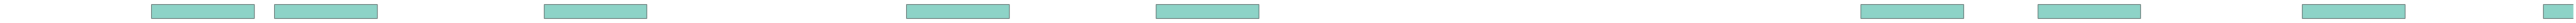

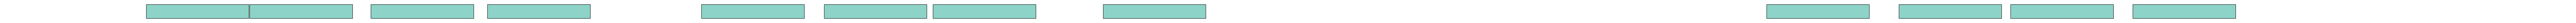

In [352]:
n_samples = 40
end = 100
for i in range(5):
    lane = cumulate(lane_gen[i])(n_samples)
    plot_schedule(lane, clean=True, custom_end_time=end)

Generate some symmetric (same lane distributions) instances with two lanes.

In [353]:
instances = []
for i in range(5):
    lane1 = cumulate(lane_gen[i])(n_samples)
    lane2 = cumulate(lane_gen[i])(n_samples)
    instances.append({
        'length': [lane1['length'][0], lane2['length'][0]],
        'release': [lane1['release'][0], lane2['release'][0]],
        'switch': vehicle_w,
    })

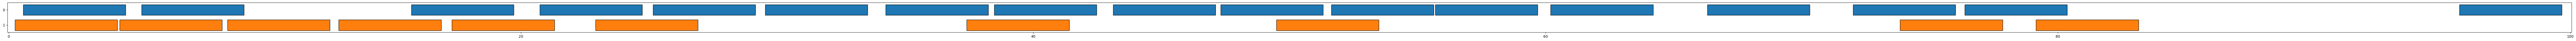

In [354]:
plot_schedule(instances[4], custom_end_time=end)

### Heuristics

In [285]:
def objective(schedule):
    """Compute total completion time objective."""
    return sum(sum(ys) for ys in schedule)

In [286]:
def earliest_lane(instance):
    """Get the lane with the earliest vehicle."""
    automaton = Automaton(instance)
    first_vehicles = { l: automaton.LB[l][0] for l in range(automaton.N) }
    return min(first_vehicles, key=first_vehicles.get)

In [287]:
def alternate_heuristic(instance, length=1):
    automaton = Automaton(instance)

    # start with "earliest" lane
    automaton.step(earliest_lane(instance))
    
    # keep track of platoon length
    counter = 1
    while not automaton.done:
        l = automaton.last_lane
        if counter >= length or automaton.k[l] == automaton.K[l]:
            counter = 0
            # next lane with unscheduled vehicles
            l = (l + 1) % automaton.N
            while automaton.k[l] == automaton.K[l]:
                l = (l + 1) % automaton.N
        automaton.step(l)
        counter += 1
    
    return automaton.y

In [288]:
def threshold_heuristic(instance, threshold=0):
    """Stay on lane while next unscheduled vehicle is close enough."""
    automaton = Automaton(instance)

    # start with the lane with the earliest vehicle
    automaton.step(earliest_lane(instance))

    while not automaton.done:
        l = automaton.last_lane
        # last scheduled vehicle
        k = automaton.k[l] - 1

        # next vehicle exists
        if k + 1 < automaton.K[l]:
            # earliest crossing time of next vehicle in lane
            r = instance['release'][l][k+1]
    
            if automaton.LB[l][k] + instance['length'][l][k] + threshold >= r:
                automaton.step(l)
                continue
    
        # next lane with unscheduled vehicles
        l = (l + 1) % automaton.N
        while automaton.k[l] == automaton.K[l]:
            l = (l + 1) % automaton.N
        automaton.step(l)

    return automaton.y

In [355]:
instance = instances[4]

13073.764057505312


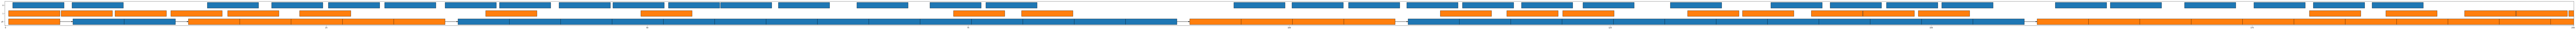

In [356]:
y = threshold_heuristic(instance, threshold=0)
print(objective(y))
plot_schedule(instance, schedules=[{'y': y}], custom_end_time=200, draw_switch=True)

1171.9384311607512


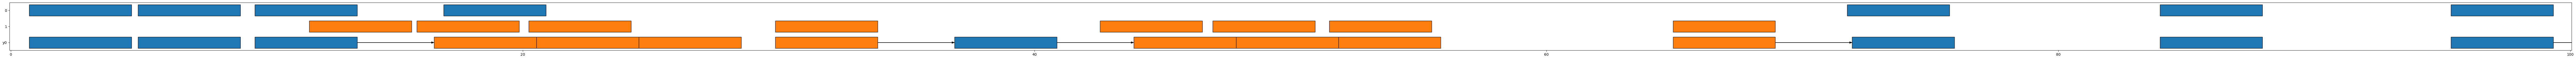

In [59]:
from exact import solve
res = solve(instance)
print(res['obj'])

plot_schedule(instance, schedules=[res], custom_end_time=100, draw_switch=True)

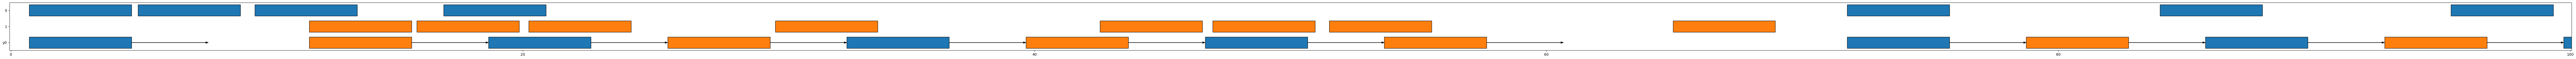

In [57]:
y_alternate = alternate_heuristic(instance, length=1)
plot_schedule(instance, schedules=[{'y': y_alternate}], custom_end_time=100, draw_switch=True)

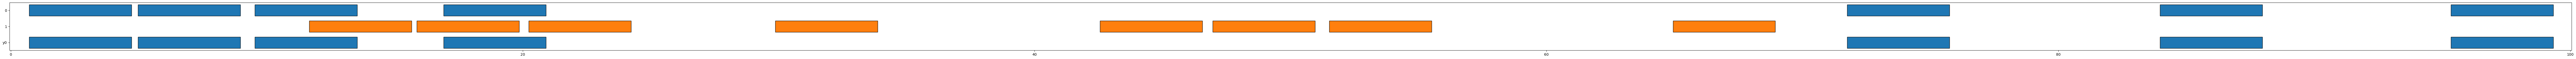

2026.1515076572352


In [58]:
y_alternate = alternate_heuristic(instance, length=10)
plot_schedule(instance, schedules=[{'y': y_alternate}], custom_end_time=100, draw_switch=True)
print(objective(y_alternate))

In [ ]:
def insertion_heuristic(instance):
    """Assumes two lanes. Iteratively "inserts" a vehicle from one lane somewhere among the vehicles of the other lane."""

    

### Export for visualization

In [357]:
import matplotlib.pyplot as plt

def motion_lane(arrivals, crossings):
    x = []
    prev = None
    for a, y in zip(arrivals, crossings):
        checkpoints = np.array([
            (a, 0),
            (y, lane_length),
        ])
        x.append(motion_synthesize(checkpoints, params, prev=prev))
        prev = (y, x[-1])
    
    return x

In [358]:
%cd /home/jeroen/repos/traffic-scheduling/
from motion.motion import motion_synthesize

params = {
    'vmax': 1, # maximum speed
    'umax': 0.5, # maximum acceleration
    'dt': 0.1, # discrete time step size
    'l': vehicle_l,    # vehicle length = minimum follow distance
}

rho = params['vmax'] / params['l']
lane_length = 200

print(f"lane length = {lane_length}")
print(f"processing time = {rho}")

/home/jeroen/repos/traffic-scheduling
lane length = 200
processing time = 0.25


In [359]:
solution = y

In [369]:
arrivals = instance['release']
crossings = np.array(solution)
trajects = {}

for l in [0, 1]:
    crossings[l] = crossings[l] + lane_length * params['vmax']
    trajects[l] = motion_lane(arrivals[l], crossings[l])

Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 209455.35
19 simplex iterations
1 branching node
absmipgap=5.82077e-10, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 208101.65
46 simplex iterations
1 branching node
absmipgap=3.7835e-10, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 238914.75
19 simplex iterations
1 branching node
absmipgap=7.27596e-10, relmipgap=3.04542e-15
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 236184.25
19 simplex iterations
1 branching node
absmipgap=6.40284e-10, relmipgap=2.71095e-15
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 234688.65
48 simplex iterations
1 branching node
absmipgap=3.20142e-10, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 233216.45
46 simplex iterations
1 branching node
absmipgap=1.16415e-10, relmipgap=0
Gurobi 11.0.2:Gurobi 11.0.2: optimal solution; objective 231227.1
46 simplex iterations
1 branching node
absmipgap=3.20142e-10, relmipg

In [370]:
max_t = 600

for l in [0, 1]:
    for i in range(len(trajects[l])):
        a = arrivals[l][i]
        y = crossings[l][i]
        tr = trajects[l][i]

        #add start and end (just full speed)
        start_t = np.arange(0, a, params['dt'])
        start_traject = -a * params['vmax'] + start_t * params['vmax']
        end_t = np.arange(y, max_t, params['dt'])
        end_traject = lane_length + (end_t - y) * params['vmax']
        
        trajects[l][i] = list(np.concatenate((start_traject, np.array(trajects[l][i]), end_traject)))

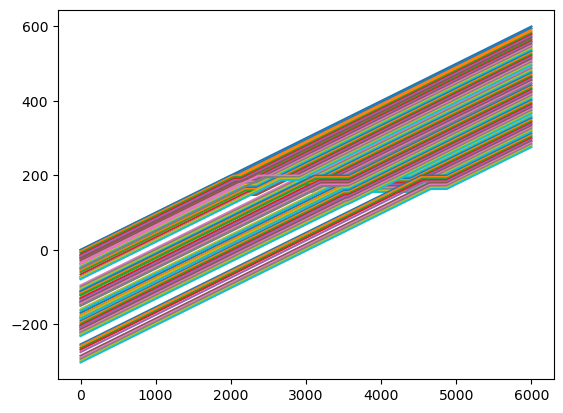

In [371]:
for l in [0, 1]:
    for i in range(len(trajects[l])):
        a = arrivals[l][i]
        y = crossings[l][i]
        tr = trajects[l][i]

        #t = [ a + i * params['dt'] for i in range(len(tr)) ]
        #plt.plot(t[:len(tr)], tr)
        plt.plot(tr)

Output to file.

In [372]:
import json
with open('trajects.json', 'w', encoding='utf-8') as f:
    json.dump(trajects, f, ensure_ascii=False, indent=4)